# Skin cancer classification using traditional CNN and [resNet50](https://keras.io/api/applications/resnet/)

### 2 Types of possible cases 
**1. Benign <br>**
**2. Malignant <br>**

## Roadmap: <br>
**Step 1 : Importing Essential Libraries**<br>
**Step 2: Loading pictures and making Dictionary of images and labels** <br>
**Step 3: Categorical Labels** <br>
**Step 4: Normalization** <br>
**Step 5: Train and Test Split** <br>
**Step 6: Model Building **<br>
**Step 7: Cross-validating model**<br>
**Step 8: Testing model**<br>
**Step 9: ResNet50** <br>

# 1 : importing libs

In [3]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras import backend as K 


Using TensorFlow backend.


# 2 : Loading pictures and converting to (w,h,3) numpy arrays & creating labels
In this step I load in the pictures and turn them into numpy arrays using their RGB values. As the pictures have already been resized to 224x224, there's no need to resize them. As the pictures do not have any labels, these need to be created. Finally, the pictures are added together to a big training set and shuffeled.

In [21]:
folder_benign_train = '../input/data/train/benign'
folder_malignant_train = '../input/data/train/malignant'

folder_benign_test = '../input/data/test/benign'
folder_malignant_test = '../input/data/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')


# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

In [ ]:
# Display first 6 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 10))
columns = 3
rows = 2

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

# 3: Categorical Labels

In [37]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [39]:
y_test[0]

array([0., 1.], dtype=float32)

# 4 : Normalization

In [40]:
X_train = X_train/255.
X_test = X_test/255.

# 5: CNN model 

In [44]:
K.clear_session()

In [45]:
# See learning curve and validation curve
def build(input_shape= (224,224,3), lr = 1e-3, num_classes= 2, init= 'normal', activ= 'relu', optim= 'adam'):
    
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)



### The model below will takes too long run even with 3 epochs and 0.01 LR .... so be **patient**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 200704)            0         
__________

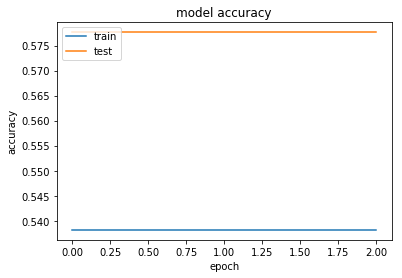

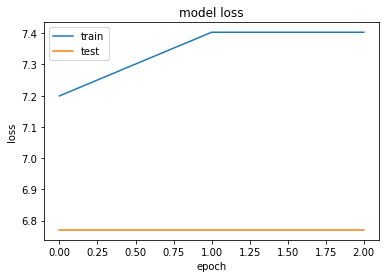

In [47]:
input_shape = (224,224,3)
lr = 1e-2 #1e-3
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 3 #50
batch_size = 64

model = build(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=0, 
                    callbacks=[learning_rate_reduction]
                   )
                   
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## We can use **data augmentation** before training the model but its not necessary in this case since all images are taken with care (all imges are almost round, centered and have the same scale and right-left padding)

In [58]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

model = build(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
history = model.fit_generator(
                    datagen.flow(X_train,y_train, batch_size=batch_size),
                    epochs= epochs,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    #callbacks=[learning_rate_reduction]
                   )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 200704)            0         
__________

In [ ]:
K.clear_session()
del model
del history

# Step 6: Cross-Validating Model


In [ ]:
# define 3-fold cross validation test harness
kfold = KFold(n_splits=3, shuffle=True, random_state=77)

cvscores = []
for train, test in kfold.split(X_train, y_train):
  # create model
    model = build(lr=lr, 
                  init= init, 
                  activ= activ, 
                  optim=optim, 
                  input_shape= input_shape)
    
    # Fit the model
    model.fit(X_train[train], y_train[train], epochs=epochs, batch_size=batch_size, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    K.clear_session()
    del model
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

# Step 7: Testing the model

First the model has to be fitted with all the data, such that no data is left out.

In [ ]:
# Fitting model to all data
model = build(lr=lr, 
              init= init, 
              activ= activ, 
              optim=optim, 
              input_shape= input_shape)

model.fit(X_train, y_train,
          epochs=epochs, batch_size= batch_size, verbose=0,
          callbacks=[learning_rate_reduction]
         )

# Testing model on test data to evaluate
y_pred = model.predict_classes(X_test)

print(accuracy_score(np.argmax(y_test, axis=1),y_pred))

In [ ]:
# save model
# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# Clear memory, because of memory overload
del model
K.clear_session()

# Step 8: ResNet50
<h3>ResNet stands for Residual Network and is a specific type of convolutional neural network (CNN) introduced in the 2015 paper “Deep Residual Learning for Image Recognition” by He Kaiming, Zhang Xiangyu, Ren Shaoqing, and Sun Jian. CNNs are commonly used to power computer vision applications.

ResNet-50 is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer). Residual neural networks are a type of artificial neural network (ANN) that forms networks by stacking residual blocks.</h3>

In [ ]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [ ]:
# Train ResNet50 on all the data
model.fit(X_train, y_train,
          epochs=epochs, batch_size= epochs, verbose=0,
          callbacks=[learning_rate_reduction]
         )


## Accuracy

In [ ]:
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

## Saving the model for deployement

In [ ]:
import pickle

with open('rn50_model', 'wb') as f:
    pickle.dump(model, f1)
print(f"Model saved at {os.getcwd()}")